# B09705039_劉惟恩_HW04

In [1]:
# load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

# Load data
with open('msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


## Q1

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# OLS
reg = LinearRegression().fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
# RMSE 
RMSE = mean_squared_error(Y_test, Y_pred, squared=False)
# first 5 features
first_5 = reg.coef_[:5]

In [3]:
print("RMSE:", RMSE)
print("First 5 features:", first_5)

RMSE: 9.510160684544397
First 5 features: [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


## Q2

In [4]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

Define Our Dataset Objects

In [5]:
class Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

Create our MLP

In [6]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        H = config['H']
        D_in = input_dim
        D_out = 1
        self.layers = nn.Sequential(
            # Layer 1
            torch.nn.Linear(D_in, H),  
            torch.nn.ReLU(),
            # Layer 2
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            # Layer 3
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            # Layer 4
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            # Output Layer
            torch.nn.Linear(H, D_out)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

Define Optimizer and Loss Function

In [7]:
# Trainer
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.
    # Define your optimization algorithm. 
    if config['optimizer'] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        
        for x, y in train_loader:
            model.train() # Set your model to train mode.
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            # loss_record.append(loss.detach().item())
            if step % 100 == 0:
                mean_train_loss = loss.detach().item()
                step_arr.append(step)
                train_loss.append(mean_train_loss)

                model.eval() # Set your model to evaluation mode.
                loss_record = []
                for x, y in valid_loader:
                    x, y = x.to(device), y.to(device)
                    with torch.no_grad():
                        pred = model(x)
                        loss = criterion(pred, y)

                    loss_record.append(loss.item())

                mean_valid_loss = sum(loss_record)/len(loss_record)
                valid_loss.append(mean_valid_loss)

                print(f'Epoch [{epoch+1}/{n_epochs}], Step[{step}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')

                if mean_valid_loss < best_loss:
                    best_loss = mean_valid_loss
                    best_step_count = step
                    torch.save(model.state_dict(), config['save_path']) # Save your best model
                    print('Saving model with loss {:.3f}...'.format(best_loss))
                    early_stop_count = 0
                else:
                    early_stop_count += 1 * 100
                
                if early_stop_count >= config['early_stop']:
                    print('\nModel is not improving, so we halt the training session.')
                    return

In [8]:
# Predictor
def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in test_loader:
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()
    return preds

Create Dataloader

In [9]:
train_dataset, valid_dataset, test_dataset = Dataset(X_subtrain, Y_subtrain), \
                                            Dataset(X_valid, Y_valid), \
                                            Dataset(X_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1000, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, pin_memory=True)

Main training code

In [10]:
# config
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
config = {
    'H': 45,
    'optimizer': "SGD",
    'weight_decay': 0,
    'n_epochs': 100,     # Number of epochs.            
    'learning_rate': 0.00001,              
    'early_stop': 5000,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model2.ckpt'  # Your model will be saved here.
}

# training
model = My_Model(input_dim=X_subtrain.shape[1]).to(device) # put your model and data on the same computation device.

step_arr = []
train_loss = []
valid_loss = []
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/100], Step[100]: Train loss: 108.8962, Valid loss: 119.3198
Saving model with loss 119.320...
Epoch [1/100], Step[200]: Train loss: 120.9847, Valid loss: 119.5186
Epoch [1/100], Step[300]: Train loss: 118.4456, Valid loss: 119.4957
Epoch [1/100], Step[400]: Train loss: 122.6091, Valid loss: 119.1775
Saving model with loss 119.177...
Epoch [2/100], Step[500]: Train loss: 128.5199, Valid loss: 119.3914
Epoch [2/100], Step[600]: Train loss: 110.4010, Valid loss: 119.5541
Epoch [2/100], Step[700]: Train loss: 120.7958, Valid loss: 119.2641
Epoch [2/100], Step[800]: Train loss: 116.4359, Valid loss: 118.9398
Saving model with loss 118.940...
Epoch [3/100], Step[900]: Train loss: 116.2152, Valid loss: 119.6781
Epoch [3/100], Step[1000]: Train loss: 137.5541, Valid loss: 119.1695
Epoch [3/100], Step[1100]: Train loss: 136.2171, Valid loss: 119.1535
Epoch [3/100], Step[1200]: Train loss: 130.1479, Valid loss: 119.2751
Epoch [4/100], Step[1300]: Train loss: 116.1454, Valid loss: 119.35

In [11]:
# testing
model = My_Model(input_dim=X_subtrain.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
test_RMSE = mean_squared_error(Y_test, preds, squared=False)

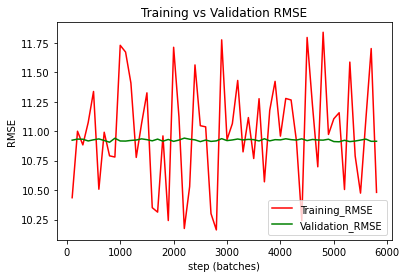

Test_RMSE: 10.853115


In [12]:
# Show results

# Change mse to rmse
train_loss = np.sqrt(train_loss)
valid_loss = np.sqrt(valid_loss)

# Draw test, valid RMSE
import matplotlib.pyplot as plt

plt.plot(step_arr, train_loss ,color = 'r', label="Training_RMSE")
plt.plot(step_arr, valid_loss ,color = 'g', label="Validation_RMSE")
plt.title("Training vs Validation RMSE")
plt.xlabel("step (batches)")
plt.ylabel("RMSE")
plt.legend(loc = "best")
plt.show()

# Print test RMSE
print("Test_RMSE:", test_RMSE)

The Training and Validation RMSE chart indicates that this may be a bad model, since the Validation RMSE line doesn't decrease as the Training RMSE decreases. Learning rate may be too small or bad optimization so it stucks in a small interval.

## Q3

H = 90

In [13]:
# config
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
config = {
    'H': 90,
    'optimizer': "SGD",
    'weight_decay': 0,
    'n_epochs': 100,     # Number of epochs.            
    'learning_rate': 0.00001,              
    'early_stop': 5000,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model3-1.ckpt'  # Your model will be saved here.
}

# training
model = My_Model(input_dim=X_subtrain.shape[1]).to(device) # put your model and data on the same computation device.

step_arr = []
train_loss = []
valid_loss = []
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/100], Step[100]: Train loss: 137.4203, Valid loss: 119.3198
Saving model with loss 119.320...
Epoch [1/100], Step[200]: Train loss: 122.8375, Valid loss: 119.4537
Epoch [1/100], Step[300]: Train loss: 112.8199, Valid loss: 118.9645
Saving model with loss 118.965...
Epoch [1/100], Step[400]: Train loss: 116.8828, Valid loss: 119.1396
Epoch [2/100], Step[500]: Train loss: 119.9847, Valid loss: 119.4945
Epoch [2/100], Step[600]: Train loss: 110.6101, Valid loss: 119.1409
Epoch [2/100], Step[700]: Train loss: 108.2575, Valid loss: 119.1559
Epoch [2/100], Step[800]: Train loss: 121.5499, Valid loss: 119.3392
Epoch [3/100], Step[900]: Train loss: 136.0451, Valid loss: 119.3951
Epoch [3/100], Step[1000]: Train loss: 120.2909, Valid loss: 119.5201
Epoch [3/100], Step[1100]: Train loss: 128.4163, Valid loss: 119.3521
Epoch [3/100], Step[1200]: Train loss: 128.5140, Valid loss: 119.2770
Epoch [4/100], Step[1300]: Train loss: 114.4646, Valid loss: 119.2292
Epoch [4/100], Step[1400]: Trai

In [14]:
# testing
model = My_Model(input_dim=X_subtrain.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
test_RMSE = mean_squared_error(Y_test, preds, squared=False)
# Print test RMSE
print("Test_RMSE:", test_RMSE)

Test_RMSE: 10.852602


H = 180

In [15]:
# config
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
config = {
    'H': 180,
    'optimizer': "SGD",
    'weight_decay': 0,
    'n_epochs': 100,     # Number of epochs.            
    'learning_rate': 0.00001,              
    'early_stop': 5000,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model3-2.ckpt'  # Your model will be saved here.
}

# training
model = My_Model(input_dim=X_subtrain.shape[1]).to(device) # put your model and data on the same computation device.

step_arr = []
train_loss = []
valid_loss = []
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/100], Step[100]: Train loss: 103.7431, Valid loss: 119.0743
Saving model with loss 119.074...
Epoch [1/100], Step[200]: Train loss: 140.2318, Valid loss: 119.2079
Epoch [1/100], Step[300]: Train loss: 110.2134, Valid loss: 119.2712
Epoch [1/100], Step[400]: Train loss: 121.1736, Valid loss: 119.2751
Epoch [2/100], Step[500]: Train loss: 111.7628, Valid loss: 119.2256
Epoch [2/100], Step[600]: Train loss: 117.2123, Valid loss: 119.6232
Epoch [2/100], Step[700]: Train loss: 109.4865, Valid loss: 119.3130
Epoch [2/100], Step[800]: Train loss: 125.5556, Valid loss: 119.4642
Epoch [3/100], Step[900]: Train loss: 98.2916, Valid loss: 119.2957
Epoch [3/100], Step[1000]: Train loss: 120.5994, Valid loss: 119.0867
Epoch [3/100], Step[1100]: Train loss: 118.3205, Valid loss: 119.5170
Epoch [3/100], Step[1200]: Train loss: 131.8839, Valid loss: 119.2263
Epoch [4/100], Step[1300]: Train loss: 105.3552, Valid loss: 119.3021
Epoch [4/100], Step[1400]: Train loss: 127.4461, Valid loss: 119.6

In [16]:
# testing
model = My_Model(input_dim=X_subtrain.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
test_RMSE = mean_squared_error(Y_test, preds, squared=False)
# Print test RMSE
print("Test_RMSE:", test_RMSE)

Test_RMSE: 10.850921


The test RMSE decreases as H increases. So we should pick H = 180 for the lowest RMSE.

## Q4

H = 45, 90, 180 Weight Decay = 0.1, 0.2, 0.4

In [17]:
h_arr = []
wd_arr = []
test_RMSE_arr = []
for h in [45,90,180]:
    for wd in [0.1, 0.2, 0.4]:
        # config
        device = 'mps' if torch.backends.mps.is_available() else 'cpu'
        config = {
            'H': h,
            'optimizer': "SGD",
            'weight_decay': wd,
            'n_epochs': 100,     # Number of epochs.            
            'learning_rate': 0.00001,              
            'early_stop': 5000,    # If model has not improved for this many consecutive epochs, stop training.     
            'save_path': './models/model' + '4_' + str(h) + "_" + str(wd) + '.ckpt'  # Your model will be saved here.
        }

        # training
        model = My_Model(input_dim=X_subtrain.shape[1]).to(device) # put your model and data on the same computation device.

        step_arr = []
        train_loss = []
        valid_loss = []
        trainer(train_loader, valid_loader, model, config, device)
        
        # testing
        model = My_Model(input_dim=X_subtrain.shape[1]).to(device)
        model.load_state_dict(torch.load(config['save_path']))
        preds = predict(test_loader, model, device)
        test_RMSE = mean_squared_error(Y_test, preds, squared=False)
        
        # append to array
        h_arr.append(h)
        wd_arr.append(wd)
        test_RMSE_arr.append(test_RMSE)

Epoch [1/100], Step[100]: Train loss: 112.9320, Valid loss: 119.0585
Saving model with loss 119.058...
Epoch [1/100], Step[200]: Train loss: 124.8216, Valid loss: 119.2890
Epoch [1/100], Step[300]: Train loss: 113.8580, Valid loss: 118.9456
Saving model with loss 118.946...
Epoch [1/100], Step[400]: Train loss: 124.5668, Valid loss: 119.4016
Epoch [2/100], Step[500]: Train loss: 124.2085, Valid loss: 119.1222
Epoch [2/100], Step[600]: Train loss: 129.5255, Valid loss: 119.0315
Epoch [2/100], Step[700]: Train loss: 118.0732, Valid loss: 119.0127
Epoch [2/100], Step[800]: Train loss: 111.0058, Valid loss: 119.1592
Epoch [3/100], Step[900]: Train loss: 111.8871, Valid loss: 119.2148
Epoch [3/100], Step[1000]: Train loss: 127.9857, Valid loss: 118.9696
Epoch [3/100], Step[1100]: Train loss: 119.0730, Valid loss: 119.2385
Epoch [3/100], Step[1200]: Train loss: 114.0680, Valid loss: 119.4213
Epoch [4/100], Step[1300]: Train loss: 114.2674, Valid loss: 119.3049
Epoch [4/100], Step[1400]: Trai

In [22]:
data = {"H": h_arr,
       "Weight Decay": wd_arr,
       "test RMSE": test_RMSE_arr}
df = pd.DataFrame(data)
display(df)

,H,Weight Decay,test RMSE
0,45,0.1,10.850842
1,45,0.2,10.852477
2,45,0.4,10.854154
3,90,0.1,10.853562
4,90,0.2,10.852452
5,90,0.4,10.852136
6,180,0.1,10.851992
7,180,0.2,10.851075
8,180,0.4,10.852359


According to the chart above, we should pick H = 45 with low weight decay. However, all of them have very similar test RMSE, which implies the optimization is not good enough.

## Q5

In [19]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        H = config['H']
        D_in = input_dim
        D_out = 1
        self.layers = nn.Sequential(
            # Layer 1
            torch.nn.Linear(D_in, H),  
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            # Layer 2
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            # Layer 3
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            # Layer 4
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            # Output Layer
            torch.nn.Linear(H, D_out)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [25]:
# config
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
config = {
    'H': 90,
    'optimizer': "Adam",
    'weight_decay': 0,
    'n_epochs': 100,     # Number of epochs.            
    'learning_rate': 0.001,              
    'early_stop': 5000,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model5.ckpt'  # Your model will be saved here.
}

# training
model = My_Model(input_dim=X_subtrain.shape[1]).to(device) # put your model and data on the same computation device.

step_arr = []
train_loss = []
valid_loss = []
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/100], Step[100]: Train loss: 88.5691, Valid loss: 88.5393
Saving model with loss 88.539...
Epoch [1/100], Step[200]: Train loss: 94.4283, Valid loss: 82.5569
Saving model with loss 82.557...
Epoch [1/100], Step[300]: Train loss: 83.7328, Valid loss: 80.7486
Saving model with loss 80.749...
Epoch [1/100], Step[400]: Train loss: 88.9798, Valid loss: 80.2941
Saving model with loss 80.294...
Epoch [2/100], Step[500]: Train loss: 80.3855, Valid loss: 78.5708
Saving model with loss 78.571...
Epoch [2/100], Step[600]: Train loss: 81.4339, Valid loss: 78.7190
Epoch [2/100], Step[700]: Train loss: 94.8027, Valid loss: 78.2034
Saving model with loss 78.203...
Epoch [2/100], Step[800]: Train loss: 78.3812, Valid loss: 77.5149
Saving model with loss 77.515...
Epoch [3/100], Step[900]: Train loss: 83.4298, Valid loss: 77.2824
Saving model with loss 77.282...
Epoch [3/100], Step[1000]: Train loss: 88.2018, Valid loss: 77.2720
Saving model with loss 77.272...
Epoch [3/100], Step[1100]: Train

In [26]:
# testing
model = My_Model(input_dim=X_subtrain.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
test_RMSE = mean_squared_error(Y_test, preds, squared=False)

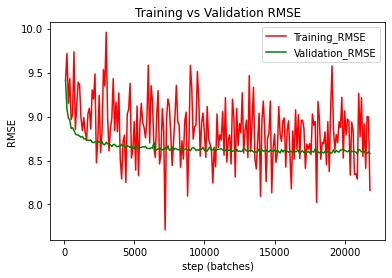

Test_RMSE: 8.772996


In [27]:
# Show results

# Change mse to rmse
train_loss = np.sqrt(train_loss)
valid_loss = np.sqrt(valid_loss)

# Draw test, valid RMSE
import matplotlib.pyplot as plt

plt.plot(step_arr, train_loss ,color = 'r', label="Training_RMSE")
plt.plot(step_arr, valid_loss ,color = 'g', label="Validation_RMSE")
plt.title("Training vs Validation RMSE")
plt.xlabel("step (batches)")
plt.ylabel("RMSE")
plt.legend(loc = "best")
plt.show()

# Print test RMSE
print("Test_RMSE:", test_RMSE)

This is obviously way better than the previous models, and we can see significant decrease of Validation RMSE with the Training RMSE decreases and finally stablizes.

## Q6

H = 20, 45, 180, 360

In [28]:
h_arr = []
test_RMSE_arr = []

for h in [20, 45, 180, 360]:
    # config
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    config = {
        'H': h,
        'optimizer': "Adam",
        'weight_decay': 0,
        'n_epochs': 100,     # Number of epochs.            
        'learning_rate': 0.001,              
        'early_stop': 5000,    # If model has not improved for this many consecutive epochs, stop training.     
        'save_path': './models/model6_' + str(h) + '.ckpt'  # Your model will be saved here.
    }

    # training
    model = My_Model(input_dim=X_subtrain.shape[1]).to(device) # put your model and data on the same computation device.

    step_arr = []
    train_loss = []
    valid_loss = []
    trainer(train_loader, valid_loader, model, config, device)
    
    # testing
    model = My_Model(input_dim=X_subtrain.shape[1]).to(device)
    model.load_state_dict(torch.load(config['save_path']))
    preds = predict(test_loader, model, device)
    test_RMSE = mean_squared_error(Y_test, preds, squared=False)
    
    # append to array
    h_arr.append(h)
    test_RMSE_arr.append(test_RMSE)

Epoch [1/100], Step[100]: Train loss: 109.2591, Valid loss: 112.4306
Saving model with loss 112.431...
Epoch [1/100], Step[200]: Train loss: 90.8071, Valid loss: 97.8137
Saving model with loss 97.814...
Epoch [1/100], Step[300]: Train loss: 105.4750, Valid loss: 91.1357
Saving model with loss 91.136...
Epoch [1/100], Step[400]: Train loss: 100.6136, Valid loss: 89.0132
Saving model with loss 89.013...
Epoch [2/100], Step[500]: Train loss: 86.6712, Valid loss: 87.3832
Saving model with loss 87.383...
Epoch [2/100], Step[600]: Train loss: 92.6837, Valid loss: 85.7146
Saving model with loss 85.715...
Epoch [2/100], Step[700]: Train loss: 85.1781, Valid loss: 85.8432
Epoch [2/100], Step[800]: Train loss: 91.4784, Valid loss: 85.3131
Saving model with loss 85.313...
Epoch [3/100], Step[900]: Train loss: 88.7411, Valid loss: 85.0992
Saving model with loss 85.099...
Epoch [3/100], Step[1000]: Train loss: 82.7051, Valid loss: 85.1593
Epoch [3/100], Step[1100]: Train loss: 102.8499, Valid loss:

In [29]:
data = {"H": h_arr,
       "test RMSE": test_RMSE_arr}
df = pd.DataFrame(data)
display(df)

,H,test RMSE
0,20,9.042443
1,45,8.857091
2,180,8.756114
3,360,8.747357


According to the chart above, we can see that as H increases, test RMSE decreases. So we sould pick H = 360 as the best model above.

## Q7

In [61]:
# Trainer
def l1l2_loss(output, target, z):
    loss = z * torch.sum((output - target)**2) + (1 - z) * torch.sum(torch.abs((output - target)))
    return loss

def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.
    # Define your optimization algorithm. 
    if config['optimizer'] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count, z = config['n_epochs'], math.inf, 0, 0, config['z']

    for epoch in range(n_epochs):
        
        for x, y in train_loader:
            model.train() # Set your model to train mode.
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)             
            loss = l1l2_loss(pred, y, z)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            # loss_record.append(loss.detach().item())
            if step % 100 == 0:
                mean_train_loss = criterion(pred, y).detach().item()
                step_arr.append(step)
                train_loss.append(mean_train_loss)

                model.eval() # Set your model to evaluation mode.
                loss_record = []
                for x, y in valid_loader:
                    x, y = x.to(device), y.to(device)
                    with torch.no_grad():
                        pred = model(x)
                        loss = criterion(pred, y)

                    loss_record.append(loss.item())

                mean_valid_loss = sum(loss_record)/len(loss_record)
                valid_loss.append(mean_valid_loss)

                print(f'Epoch [{epoch+1}/{n_epochs}], Step[{step}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')

                if mean_valid_loss < best_loss:
                    best_loss = mean_valid_loss
                    best_step_count = step
                    torch.save(model.state_dict(), config['save_path']) # Save your best model
                    print('Saving model with loss {:.3f}...'.format(best_loss))
                    early_stop_count = 0
                else:
                    early_stop_count += 1 * 100
                
                if early_stop_count >= config['early_stop']:
                    print('\nModel is not improving, so we halt the training session.')
                    return

In [31]:
# config
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
config = {
    'H': 90,
    'z': 0.5,
    'optimizer': "Adam",
    'weight_decay': 0,
    'n_epochs': 100,     # Number of epochs.            
    'learning_rate': 0.001,              
    'early_stop': 5000,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model7_0.5.ckpt'  # Your model will be saved here.
}

# training
model = My_Model(input_dim=X_subtrain.shape[1]).to(device) # put your model and data on the same computation device.

step_arr = []
train_loss = []
valid_loss = []
trainer(train_loader, valid_loader, model, config, device)

/Users/liuweien/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/autograd/__init__.py:191: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100], Step[100]: Train loss: 110.1659, Valid loss: 90.1538
Saving model with loss 90.154...
Epoch [1/100], Step[200]: Train loss: 93.6751, Valid loss: 82.9010
Saving model with loss 82.901...
Epoch [1/100], Step[300]: Train loss: 90.7892, Valid loss: 81.2018
Saving model with loss 81.202...
Epoch [1/100], Step[400]: Train loss: 83.2891, Valid loss: 80.4566
Saving model with loss 80.457...
Epoch [2/100], Step[500]: Train loss: 86.2609, Valid loss: 79.3374
Saving model with loss 79.337...
Epoch [2/100], Step[600]: Train loss: 82.3259, Valid loss: 79.2036
Saving model with loss 79.204...
Epoch [2/100], Step[700]: Train loss: 76.8943, Valid loss: 78.8872
Saving model with loss 78.887...
Epoch [2/100], Step[800]: Train loss: 78.8623, Valid loss: 78.0850
Saving model with loss 78.085...
Epoch [3/100], Step[900]: Train loss: 95.1142, Valid loss: 77.6287
Saving model with loss 77.629...
Epoch [3/100], Step[1000]: Train loss: 78.9057, Valid loss: 77.0546
Saving model with loss 77.055..

In [32]:
# testing
model = My_Model(input_dim=X_subtrain.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
test_RMSE = mean_squared_error(Y_test, preds, squared=False)

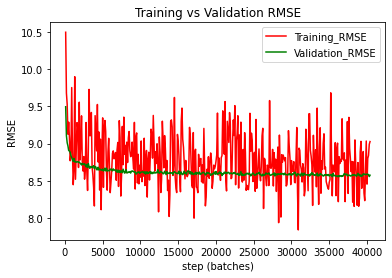

Test_RMSE: 8.742596


In [51]:
# Show results

# Change mse to rmse
train_loss = np.sqrt(train_loss)
valid_loss = np.sqrt(valid_loss)

# Draw test, valid RMSE
import matplotlib.pyplot as plt

plt.plot(step_arr, train_loss ,color = 'r', label="Training_RMSE")
plt.plot(step_arr, valid_loss ,color = 'g', label="Validation_RMSE")
plt.title("Training vs Validation RMSE")
plt.xlabel("step (batches)")
plt.ylabel("RMSE")
plt.legend(loc = "best")
plt.show()

# Print test RMSE
print("Test_RMSE:", test_RMSE)

This is a better model compared with the previous models, we can see significant decrease of Validation RMSE with the Training RMSE decreases and finally stablizes.

In [62]:
z_arr = []
test_RMSE_arr = []

for z in [0, 0.1, 0.9, 1]:
    # config
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    config = {
        'H': 90,
        'z': z,
        'optimizer': "Adam",
        'weight_decay': 0,
        'n_epochs': 100,     # Number of epochs.            
        'learning_rate': 0.001,              
        'early_stop': 5000,    # If model has not improved for this many consecutive epochs, stop training.     
        'save_path': './models/model7_' + str(z) +'.ckpt'  # Your model will be saved here.
    }

    # training
    model = My_Model(input_dim=X_subtrain.shape[1]).to(device) # put your model and data on the same computation device.

    step_arr = []
    train_loss = []
    valid_loss = []
    trainer(train_loader, valid_loader, model, config, device)

    # testing
    model = My_Model(input_dim=X_subtrain.shape[1]).to(device)
    model.load_state_dict(torch.load(config['save_path']))
    preds = predict(test_loader, model, device)
    test_RMSE = mean_squared_error(Y_test, preds, squared=False)
    
    # append to array
    z_arr.append(z)
    test_RMSE_arr.append(test_RMSE)

Epoch [1/100], Step[100]: Train loss: 117.5715, Valid loss: 112.2038
Saving model with loss 112.204...
Epoch [1/100], Step[200]: Train loss: 113.2742, Valid loss: 101.7296
Saving model with loss 101.730...
Epoch [1/100], Step[300]: Train loss: 96.1377, Valid loss: 89.0405
Saving model with loss 89.041...
Epoch [1/100], Step[400]: Train loss: 80.0840, Valid loss: 86.7423
Saving model with loss 86.742...
Epoch [2/100], Step[500]: Train loss: 107.5401, Valid loss: 85.1521
Saving model with loss 85.152...
Epoch [2/100], Step[600]: Train loss: 96.8539, Valid loss: 83.3410
Saving model with loss 83.341...
Epoch [2/100], Step[700]: Train loss: 84.5248, Valid loss: 83.8596
Epoch [2/100], Step[800]: Train loss: 87.1753, Valid loss: 82.1575
Saving model with loss 82.157...
Epoch [3/100], Step[900]: Train loss: 95.8421, Valid loss: 83.4351
Epoch [3/100], Step[1000]: Train loss: 90.0653, Valid loss: 82.5300
Epoch [3/100], Step[1100]: Train loss: 88.9019, Valid loss: 81.4825
Saving model with loss 

In [63]:
data = {"z": z_arr,
       "test RMSE": test_RMSE_arr}
df = pd.DataFrame(data)
display(df)

,z,test RMSE
0,0.0,8.947004
1,0.1,8.756169
2,0.9,8.768911
3,1.0,8.782481


According to the chart above, z = 0.1 has the best result. Thus, we should pick z = 0.1 as the best model among all.

## Q8

In [55]:
# Trainer
def l2Cust_loss(output, target, z):
    c = torch.nn.functional.relu(output - target)
    d = torch.nn.functional.relu(target - output)
    loss = z * torch.sum((output - target)**2) + (1 - z) * torch.sum(0.5 * c + 0.5 * d)
    return loss

def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.
    # Define your optimization algorithm. 
    if config['optimizer'] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count, z = config['n_epochs'], math.inf, 0, 0, config['z']

    for epoch in range(n_epochs):
        
        for x, y in train_loader:
            model.train() # Set your model to train mode.
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)             
            loss = l2Cust_loss(pred, y, z)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            # loss_record.append(loss.detach().item())
            if step % 100 == 0:
                mean_train_loss = criterion(pred, y).detach().item()
                step_arr.append(step)
                train_loss.append(mean_train_loss)

                model.eval() # Set your model to evaluation mode.
                loss_record = []
                for x, y in valid_loader:
                    x, y = x.to(device), y.to(device)
                    with torch.no_grad():
                        pred = model(x)
                        loss = criterion(pred, y)

                    loss_record.append(loss.item())

                mean_valid_loss = sum(loss_record)/len(loss_record)
                valid_loss.append(mean_valid_loss)

                print(f'Epoch [{epoch+1}/{n_epochs}], Step[{step}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')

                if mean_valid_loss < best_loss:
                    best_loss = mean_valid_loss
                    best_step_count = step
                    torch.save(model.state_dict(), config['save_path']) # Save your best model
                    print('Saving model with loss {:.3f}...'.format(best_loss))
                    early_stop_count = 0
                else:
                    early_stop_count += 1 * 100
                
                if early_stop_count >= config['early_stop']:
                    print('\nModel is not improving, so we halt the training session.')
                    return

In [56]:
# config
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
config = {
    'H': 90,
    'z': 0,
    'optimizer': "Adam",
    'weight_decay': 0,
    'n_epochs': 100,     # Number of epochs.            
    'learning_rate': 0.001,              
    'early_stop': 5000,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model8_0.ckpt'  # Your model will be saved here.
}

# training
model = My_Model(input_dim=X_subtrain.shape[1]).to(device) # put your model and data on the same computation device.

step_arr = []
train_loss = []
valid_loss = []
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/100], Step[100]: Train loss: 124.2908, Valid loss: 111.7897
Saving model with loss 111.790...
Epoch [1/100], Step[200]: Train loss: 101.9424, Valid loss: 99.5189
Saving model with loss 99.519...
Epoch [1/100], Step[300]: Train loss: 77.6261, Valid loss: 88.5082
Saving model with loss 88.508...
Epoch [1/100], Step[400]: Train loss: 92.8713, Valid loss: 86.7517
Saving model with loss 86.752...
Epoch [2/100], Step[500]: Train loss: 96.7650, Valid loss: 85.9678
Saving model with loss 85.968...
Epoch [2/100], Step[600]: Train loss: 90.7457, Valid loss: 83.9398
Saving model with loss 83.940...
Epoch [2/100], Step[700]: Train loss: 80.1885, Valid loss: 84.5056
Epoch [2/100], Step[800]: Train loss: 80.2598, Valid loss: 83.2815
Saving model with loss 83.282...
Epoch [3/100], Step[900]: Train loss: 74.1942, Valid loss: 81.9020
Saving model with loss 81.902...
Epoch [3/100], Step[1000]: Train loss: 95.5184, Valid loss: 82.3475
Epoch [3/100], Step[1100]: Train loss: 89.7762, Valid loss: 8

In [57]:
# testing
model = My_Model(input_dim=X_subtrain.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
test_RMSE = mean_squared_error(Y_test, preds, squared=False)

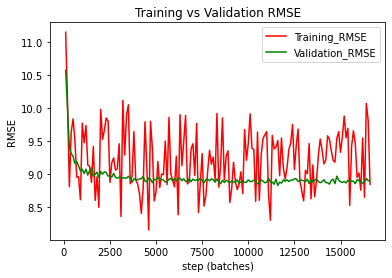

Test_RMSE: 8.957025


In [58]:
# Show results

# Change mse to rmse
train_loss = np.sqrt(train_loss)
valid_loss = np.sqrt(valid_loss)

# Draw test, valid RMSE
import matplotlib.pyplot as plt

plt.plot(step_arr, train_loss ,color = 'r', label="Training_RMSE")
plt.plot(step_arr, valid_loss ,color = 'g', label="Validation_RMSE")
plt.title("Training vs Validation RMSE")
plt.xlabel("step (batches)")
plt.ylabel("RMSE")
plt.legend(loc = "best")
plt.show()

# Print test RMSE
print("Test_RMSE:", test_RMSE)

This is not better that Q7 compared with the previous models, but we can still see significant decrease of Validation RMSE with the Training RMSE decreases and finally stablizes.

In [59]:
z_arr = []
test_RMSE_arr = []

for z in [0.1, 0.5, 0.9, 1]:
    # config
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    config = {
        'H': 90,
        'z': z,
        'optimizer': "Adam",
        'weight_decay': 0,
        'n_epochs': 100,     # Number of epochs.            
        'learning_rate': 0.001,              
        'early_stop': 5000,    # If model has not improved for this many consecutive epochs, stop training.     
        'save_path': './models/model8_' + str(z) +'.ckpt'  # Your model will be saved here.
    }

    # training
    model = My_Model(input_dim=X_subtrain.shape[1]).to(device) # put your model and data on the same computation device.

    step_arr = []
    train_loss = []
    valid_loss = []
    trainer(train_loader, valid_loader, model, config, device)

    # testing
    model = My_Model(input_dim=X_subtrain.shape[1]).to(device)
    model.load_state_dict(torch.load(config['save_path']))
    preds = predict(test_loader, model, device)
    test_RMSE = mean_squared_error(Y_test, preds, squared=False)
    
    # append to array
    z_arr.append(z)
    test_RMSE_arr.append(test_RMSE)

Epoch [1/100], Step[100]: Train loss: 97.7717, Valid loss: 90.6140
Saving model with loss 90.614...
Epoch [1/100], Step[200]: Train loss: 91.2308, Valid loss: 82.2675
Saving model with loss 82.267...
Epoch [1/100], Step[300]: Train loss: 85.4218, Valid loss: 81.3424
Saving model with loss 81.342...
Epoch [1/100], Step[400]: Train loss: 77.6237, Valid loss: 80.7211
Saving model with loss 80.721...
Epoch [2/100], Step[500]: Train loss: 82.8400, Valid loss: 78.6017
Saving model with loss 78.602...
Epoch [2/100], Step[600]: Train loss: 84.2157, Valid loss: 78.4620
Saving model with loss 78.462...
Epoch [2/100], Step[700]: Train loss: 86.2093, Valid loss: 78.1903
Saving model with loss 78.190...
Epoch [2/100], Step[800]: Train loss: 72.7657, Valid loss: 77.3834
Saving model with loss 77.383...
Epoch [3/100], Step[900]: Train loss: 69.5948, Valid loss: 76.7159
Saving model with loss 76.716...
Epoch [3/100], Step[1000]: Train loss: 81.1005, Valid loss: 76.9990
Epoch [3/100], Step[1100]: Train

In [60]:
data = {"z": z_arr,
       "test RMSE": test_RMSE_arr}
df = pd.DataFrame(data)
display(df)

,z,test RMSE
0,0.1,8.789698
1,0.5,8.784971
2,0.9,8.774449
3,1.0,8.773116


According to the chart above, bigger z implies to lower test RMSE. Thus, we should pick z = 1 as the best model among all.

#### Code Reference: https://colab.research.google.com/drive/1FTcG6CE-HILnvFztEFKdauMlPKfQvm5Z#scrollTo=YdttVRkAfu2t (NTUEE MACHINE LEARNING 2022 SPRING https://speech.ee.ntu.edu.tw/~hylee/ml/2022-spring.php)